In [1]:
import torch
import torch.nn as nn
import matplotlib.pyplot as plt
from utils.grad import grad, batch_grad
from tqdm import tqdm
from math import exp

In [2]:
device = torch.device('cpu')

# Function

In [3]:
f = lambda x: (x * torch.exp(-(x ** 2))).squeeze()
dfdx = lambda x: ((1 - 2 * x ** 2) * torch.exp(-(x ** 2))).squeeze()

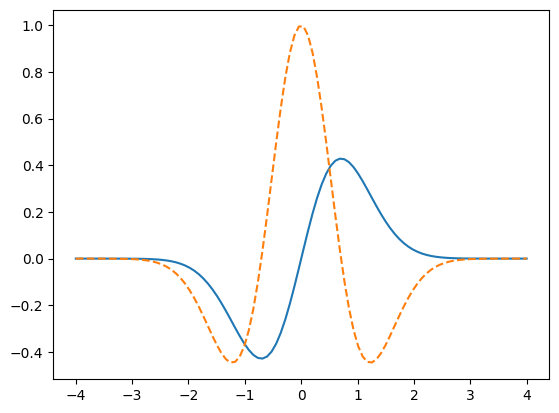

In [4]:
x_range = torch.linspace(-4, 4, 100)
plt.plot(x_range, f(x_range))
plt.plot(x_range, batch_grad(f)(x_range), linestyle='dashed')

# Model

In [5]:
class MLP(nn.Module):

    def __init__(self):
        super().__init__()

        h = 16
        self.mlp = nn.Sequential(
            nn.Linear(1, h), 
            nn.LayerNorm(h), 
            nn.SiLU(), 
            #nn.Dropout(0.5), 
            nn.Linear(h, 1)
        )
        
        nn.init.normal_(self.mlp[0].bias.data, std=0.5)
        nn.init.normal_(self.mlp[-1].bias.data, std=0.5)
    
    def forward(self, x):
        return self.mlp(x).squeeze()

# Sampler

In [6]:
class HMC():
    '''
    Hamiltonian Monte Carlo sampler
    '''
    def __init__(self, device=torch.device('cpu')):
        self.device=device
        self.beta = 0
        self.potential = lambda J : 0
        self.grad_potential = lambda J : 0
        self.kinetic = lambda v: (v ** 2) / 2
    
    @torch.no_grad
    def solve(self, x, v, dt=0.001, runtime=32):

        v -= 0.5 * dt * self.beta * self.grad_potential(x)
        x += dt * v
        
        for t in range(runtime):
            v -= dt * self.beta * self.grad_potential(x)
            x += dt * v
    
        v -= 0.5 * dt * self.beta * self.grad_potential(x)
        
        return x, v

    def step(self, x_0):

        v_0 = torch.randn_like(x_0, device=self.device)
        H_0 = self.beta * self.potential(x_0) + self.kinetic(v_0)

        x, v = self.solve(x_0, v_0)
        
        H = self.beta * self.potential(x) + self.kinetic(v)
        
        p_accept = torch.exp(H_0 - H)
        
        mask = (p_accept > torch.rand_like(p_accept, device=self.device))

        return torch.where(mask, x, x_0)

# Training

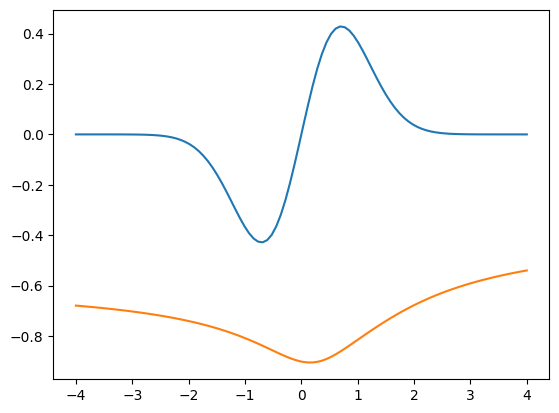

In [7]:
g = MLP()
g.to(device);
optimizer = torch.optim.Adam(g.parameters())

sampler = HMC(device)

g.eval()
x_range = torch.linspace(-4, 4, 100).unsqueeze(1)
plt.plot(x_range, f(x_range))
plt.plot(x_range, g(x_range).detach())

In [14]:
epoch = 0
epochs = 512

beta = lambda epoch : 64/(1 + exp(-16 * (epoch - (epochs / 2))/epochs))

losses = []
x = torch.randn(8, 1, device=device).detach()
xs = []

100%|█████████████████████████████████████████| 512/512 [00:13<00:00, 38.62it/s]


AttributeError: 'list' object has no attribute 't'

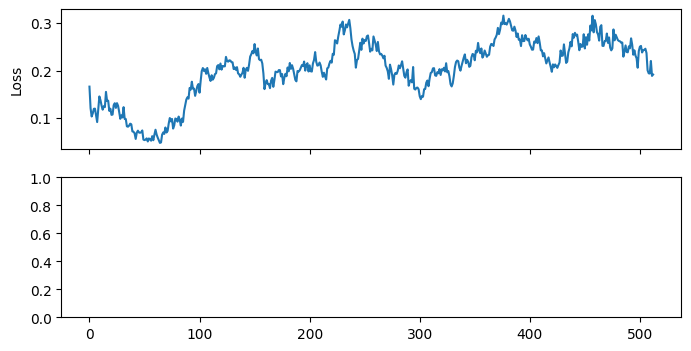

In [16]:
g.train()
for epoch in tqdm(range(epoch, epoch + epochs)):

    optimizer.zero_grad()
    
    sampler.beta = beta(epoch)
    sampler.potential = lambda x : batch_grad(g)(x) ** 2
    sampler.grad_potential = batch_grad(lambda x : grad(g)(x).squeeze() ** 2)
    
    x = sampler.step(x).detach()
    
    dg = batch_grad(g)(x)
    df = (dfdx(x) + torch.randn_like(x) * 0.1).detach()

    loss = torch.mean((dg - df) ** 2)
    loss.backward()
    optimizer.step()

    losses.append(float(loss))
    xs.append(x)

fig, (ax0, ax1) = plt.subplots(2, 1, figsize=(8, 4), sharex=True)
ax0.plot(losses)
ax0.set_ylabel('Loss')
for trajectory in torch.cat(xs.t()):
    ax1.plot(trajectory)
ax1.set_ylabel(r'$x$')

In [ ]:
g.eval()
x_range = torch.linspace(-4, 4, 100).unsqueeze(1)
plt.plot(x_range, f(x_range))
plt.plot(x_range, g(x_range).detach())

potential = lambda x: grad(g)(x).squeeze() ** 2 - g(x)
batch_potential = lambda x: batch_grad(g)(x).squeeze() ** 2 - g(x)

plt.plot(x_range, batch_potential(x_range).detach(), linestyle='dotted')
plt.plot(x_range, batch_grad(potential)(x_range).detach())

In [ ]:
potential = lambda x : beta(epoch) * (grad(g)(x).squeeze() ** 2 - g(x))
batch_potential = lambda x : beta(epoch) * (batch_grad(g)(x).squeeze() ** 2 - g(x))

x = torch.randn(16, 1, device=device)

batch_grad(sampler.potential)(x)